In [1]:
# from google.colab import drive
# drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
# import libraries


import copy
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier


In [3]:
#load dataset


data_frist_part = "/content/gdrive/MyDrive/Colab Notebooks/project_4/adult.data"
data_second_part = "/content/gdrive/MyDrive/Colab Notebooks/project_4/adult.test"


data = pd.read_csv(data_frist_part)
data.columns =['age', 'workclass', 'finalnlweight', 'education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','cpital-loss','hours-per-week','native-country','income']
second_data = pd.read_csv(data_second_part,skiprows=1)
second_data.columns =['age', 'workclass', 'finalnlweight', 'education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','cpital-loss','hours-per-week','native-country','income']

raw_data = pd.concat([data, second_data])
raw_data.head()




age          workclass  ...  native-country  income
0   50   Self-emp-not-inc  ...   United-States   <=50K
1   38            Private  ...   United-States   <=50K
2   53            Private  ...   United-States   <=50K
3   28            Private  ...            Cuba   <=50K
4   37            Private  ...   United-States   <=50K

[5 rows x 15 columns]

In [4]:
# method for creating table from dataframe


def data_frame_convert_to_table(df):
    if not isinstance(df, pd.DataFrame):
        return
    df_columns = df.columns.tolist() 
    max_len_in_lst = lambda lst: len(sorted(lst, reverse=True, key=len)[0])
    align_center = lambda st, sz: "{0}{1}{0}".format(" "*(1+(sz-len(st))//2), st)[:sz] if len(st) < sz else st
    align_right = lambda st, sz: "{0}{1} ".format(" "*(sz-len(st)-1), st) if len(st) < sz else st
    max_col_len = max_len_in_lst(df_columns)
    max_val_len_for_col = dict([(col, max_len_in_lst(df.iloc[:,idx].astype('str'))) for idx, col in enumerate(df_columns)])
    col_sizes = dict([(col, 2 + max(max_val_len_for_col.get(col, 0), max_col_len)) for col in df_columns])
    build_hline = lambda row: '+'.join(['-' * col_sizes[col] for col in row]).join(['+', '+'])
    build_data = lambda row, align: "|".join([align(str(val), col_sizes[df_columns[idx]]) for idx, val in enumerate(row)]).join(['|', '|'])
    hline = build_hline(df_columns)
    out = [hline, build_data(df_columns, align_center), hline]
    for _, row in df.iterrows():
        out.append(build_data(row.tolist(), align_right))
    out.append(hline)
    return "\n".join(out)


# descriptive analysis of raw data

def descriptive_analysis(data):

    numeric_value, string_value, datetime_value = [dict() for _ in range(3)]

    string_nan, numeric_nan, datetime_nan, string_unique, numeric_unique, datetime_unique = (
            list() for _ in range(6))

    for column_name in data.columns:
        if is_string_dtype(data[column_name]):

            dataframe_signal = pd.DataFrame(data[column_name], columns=[column_name])

            count_for_inf = 0
            count_for_neginf = 0
            for values in dataframe_signal[column_name]:
                if values == np.inf:
                    count_for_inf += 1
                if values == -np.inf:
                    count_for_neginf += 1
            replace_inf = dataframe_signal.replace([np.inf, -np.inf], np.nan)
            drop_nan_value = replace_inf.dropna(how='all')

            describe = drop_nan_value.describe(include="all")
            string_value.setdefault("content", []).append(column_name)
            string_value.setdefault("Total length", []).append(len(dataframe_signal))
            string_nan += [isna for isna in dataframe_signal.isna().sum()]

            string_value["no. of NaN"] = string_nan
            string_value.setdefault("No of inf", []).append(count_for_inf)
            string_value.setdefault("No of -inf", []).append(count_for_neginf)
            string_unique += [nunique for nunique in dataframe_signal.nunique()]
            string_value["no. of Unique"] = string_unique
            string_value.setdefault("top", []).append(describe.iat[2, 0])
            string_value.setdefault("freq", []).append(describe.iat[3, 0])
            string_value.setdefault("type", [])
            string_value["type"] += [str(dtype) for dtype in dataframe_signal.dtypes]

        elif is_numeric_dtype(data[column_name]):

            dataframe_signal = pd.DataFrame(data, columns=[column_name])
            count_for_inf = 0
            count_for_neginf = 0
            for values in dataframe_signal[column_name]:
                if values == np.inf:
                    count_for_inf += 1
                if values == -np.inf:
                    count_for_neginf += 1
            replace_inf = dataframe_signal.replace([np.inf, -np.inf], np.nan)
            drop_nan_value = replace_inf.dropna(how='all')
            describe = drop_nan_value.describe(include="all")
            numeric_value.setdefault("content", []).append(column_name)
            numeric_value.setdefault("Total length", []).append(len(dataframe_signal))
            numeric_nan += [isna for isna in dataframe_signal.isna().sum()]
            numeric_value["no. of NaN"] = numeric_nan
            numeric_value.setdefault("No of inf", []).append(count_for_inf)
            numeric_value.setdefault("No of -inf", []).append(count_for_neginf)
            numeric_unique += [nunique for nunique in dataframe_signal.nunique()]
            numeric_value["no. of Unique"] = numeric_unique
            numeric_value.setdefault("min", []).append(describe.iat[3, 0])
            numeric_value.setdefault("max", []).append(describe.iat[7, 0])
            numeric_value.setdefault("mean", []).append(round(describe.iat[1, 0]))
            numeric_value.setdefault("std", []).append(round(describe.iat[2, 0]))
            numeric_value.setdefault("q(25%)", []).append(describe.iat[4, 0])
            numeric_value.setdefault("q(50%)", []).append(describe.iat[5, 0])
            numeric_value.setdefault("q(75%)", []).append(describe.iat[6, 0])
            numeric_value.setdefault("type", [])
            numeric_value["type"] += [str(dtype) for dtype in dataframe_signal.dtypes]

    output_data = dict(
        table_numeric=numeric_value,
        table_string=string_value,

    )

    return output_data


outpot_descriptive_analysis = descriptive_analysis(raw_data)

for content, value in outpot_descriptive_analysis.items():
    data_frame_for_table = pd.DataFrame(data=value)


    print(data_frame_convert_to_table(data_frame_for_table))

    



+----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|     content    |  Total length |   no. of NaN  |    No of inf  |   No of -inf  |  no. of Unique|       min     |       max     |      mean     |       std     |     q(25%)    |     q(50%)    |     q(75%)    |      type     |
+----------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+---------------+
|            age |         48840 |             0 |             0 |             0 |            74 |          17.0 |          90.0 |          39.0 |          14.0 |          28.0 |          37.0 |          48.0 |         int64 |
|  finalnlweight |         48840 |             0 |             0 |             0 |         2

In [5]:
""" 
Here we have sometime spaces in catagorycal feature.
That's why we will try to remove space from feature
value. Then we recognize in income feature we will have two benchmark but
we have dot , so we also try to replace data here. 
"""

#Data cleaning


for column in raw_data.columns:
  try:
    raw_data[column] = raw_data[column].str.replace(' ', '')

  except:
    pass


raw_data["income"] =raw_data['income'].replace('<=50K.' ,'<=50K')
raw_data["income"] =raw_data['income'].replace('>50K.' ,'>50K')



In [6]:
""" 
In this section we would encode lebel catagorical data 
as neumerical to feed the ML classifiers. 
"""

#Dta prepossessing
 

labelencoder = LabelEncoder()

def levelEncoderColumn(dataframe, columnName, EncodedColumnName):
    dataCollumn = dataframe[columnName]
    if dataCollumn.dtypes == 'object':
        dataframe[EncodedColumnName] = labelencoder.fit_transform(dataCollumn)
    else: 
        raise Exception("Column datatype should be 'object'")

def levelEncoderAll(dataframe):
    for colName in dataframe.columns:
        if dataframe[colName].dtypes == 'object':
            dataframe[colName] = labelencoder.fit_transform(dataframe[colName])

    return dataframe

  
level_data_frame = levelEncoderAll(copy.deepcopy(raw_data))

print(level_data_frame)





       age  workclass  finalnlweight  ...  hours-per-week  native-country  income
0       50          6          83311  ...              13              39       0
1       38          4         215646  ...              40              39       0
2       53          4         234721  ...              40              39       0
3       28          4         338409  ...              40               5       0
4       37          4         284582  ...              40              39       0
...    ...        ...            ...  ...             ...             ...     ...
16275   39          4         215419  ...              36              39       0
16276   64          0         321403  ...              40              39       0
16277   38          4         374983  ...              50              39       0
16278   44          4          83891  ...              40              39       0
16279   35          5         182148  ...              60              39       1

[48840 rows x 1

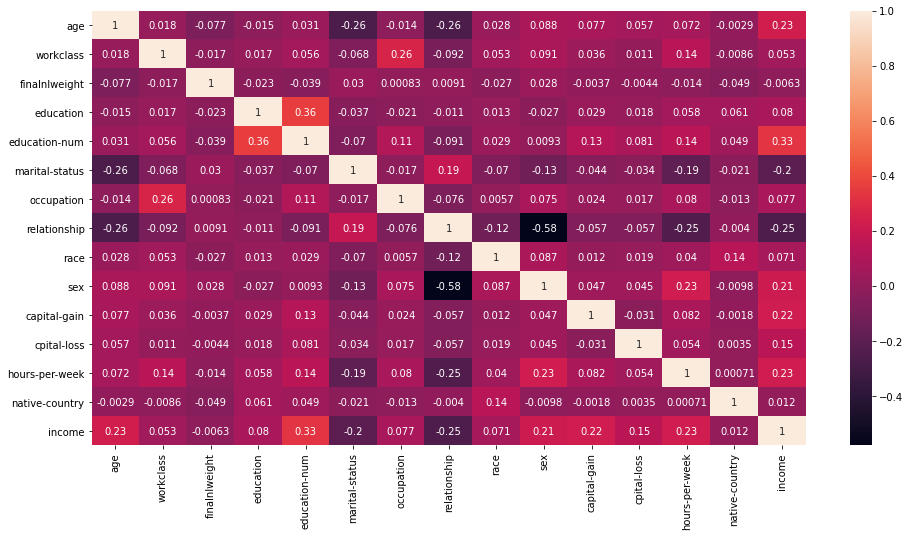

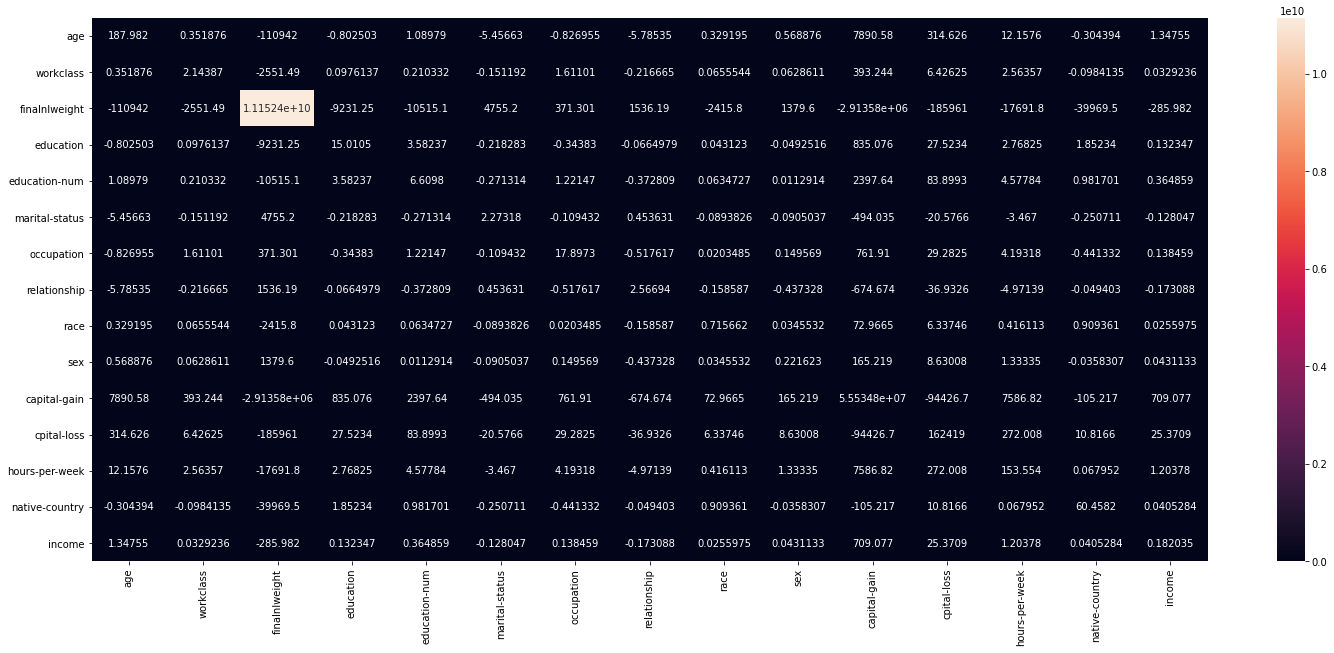

In [7]:
# Corelation matrix to see relation between each other feature 


corrMatrix = level_data_frame.corr()
plt.figure(figsize=(16, 8))
sn.heatmap(corrMatrix, annot=True)
plt.show()


# Covariance matrix  

covMatrix = level_data_frame.cov()
plt.figure(figsize=(25, 10))
sn.heatmap(covMatrix, annot=True, fmt='g')
plt.show()

In [8]:
# lets see how is feature is related with income 


def create_plot_to_see_relation_with_target(plot_data_frame,column_list):
    fig = px.scatter_matrix(plot_data_frame,
    dimensions=column_list,
    color="income")
    fig.show()



# see relations


create_plot_to_see_relation_with_target(raw_data, ["age","sex"])
create_plot_to_see_relation_with_target(raw_data, ["marital-status","native-country"])
create_plot_to_see_relation_with_target(raw_data, ["occupation","relationship"])
create_plot_to_see_relation_with_target(raw_data, ["education","education-num"])



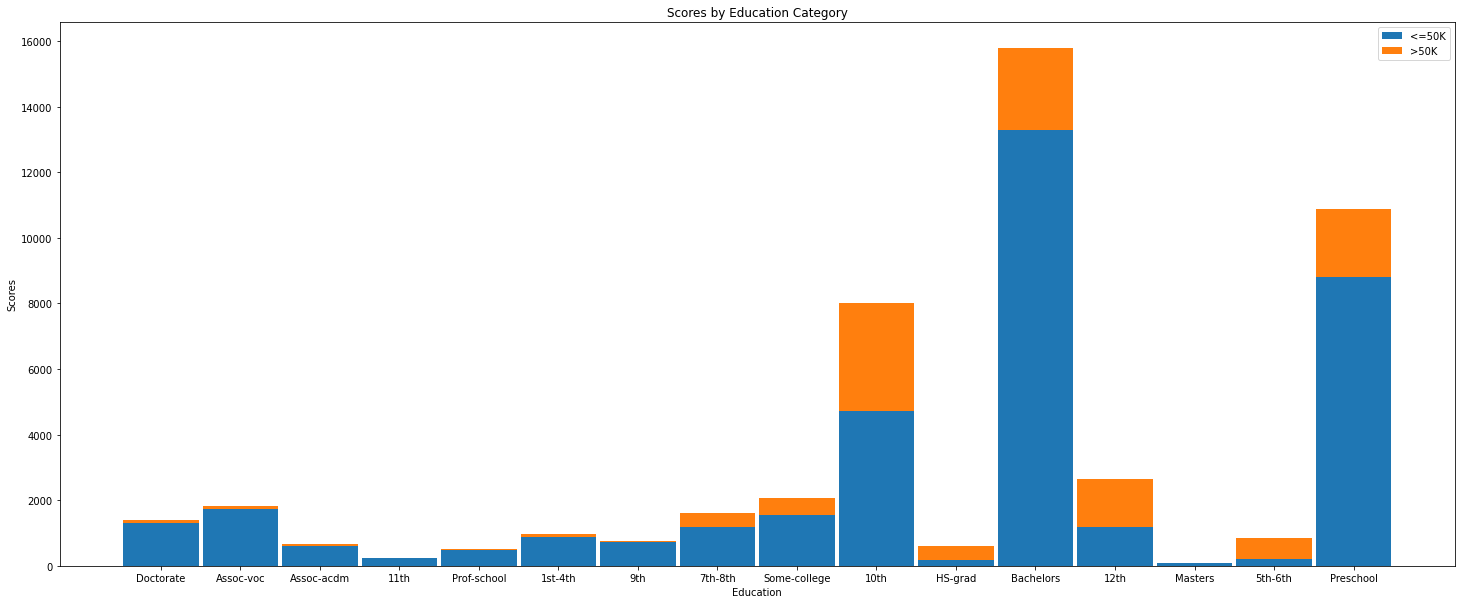

In [9]:
w = 0.95

raw_data["level_target"] = level_data_frame["income"]
df = pd.pivot_table(raw_data, index=['education', 'income'], values='level_target', aggfunc=['count'], fill_value=0).reset_index()
df.columns = ['education', 'income', 'count']
labels = list(set(list(df["education"])))
greater_than_fity = df[df["income"] == "<=50K"]
less_than_fity = df[df["income"] == ">50K"]
greater_than_fity = list(greater_than_fity["count"])
less_than_fity = list(less_than_fity["count"])


plt.figure(figsize=(25, 10))
plt.bar(labels,greater_than_fity,w,label="<=50K")
plt.bar(labels,less_than_fity,w,bottom=greater_than_fity,label=">50K")

plt.xlabel("Education")
plt.ylabel("Scores")
plt.title("Scores by Education Category")
plt.legend()
plt.show()

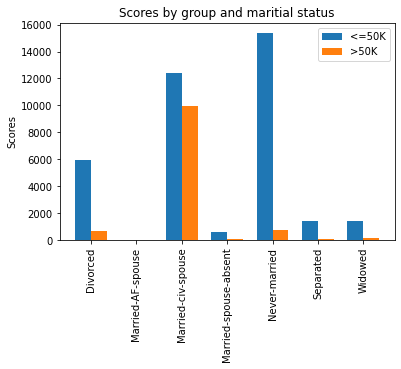

<Figure size 432x288 with 0 Axes>

In [10]:
# multibar plot


raw_data["level_target"] = level_data_frame["income"]
df = pd.pivot_table(raw_data, index=['marital-status', 'income'], values='level_target', aggfunc=['count', 'sum']).reset_index()

df.columns = ['marital-status', 'income', 'count', 'sum']
labels = list(df["marital-status"].unique())


less_than_fity = df[df["income"] == "<=50K"]
greater_than_fity = df[df["income"] == ">50K"]


less_then = list(less_than_fity["count"])
greater_then = list(greater_than_fity["count"])

raw_data.drop(["level_target"], axis=1, inplace=True)





x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, less_then, width, label='<=50K')
rects2 = ax.bar(x + width/2, greater_then, width, label='>50K')



# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by group and maritial status')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)



def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()

plt.show()
plt.savefig('maritial_status_income')

      sex income        count          sum
                 level_target level_target
0  Female  <=50K        14423            0
1  Female   >50K         1769         1769
2    Male  <=50K        22730            0
3    Male   >50K         9918         9918


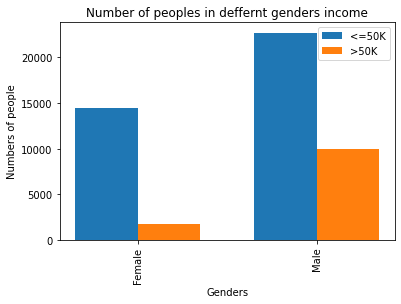

In [11]:
# multibar plot for defferent genders

raw_data["level_target"] = level_data_frame["income"]
df = pd.pivot_table(raw_data, index=['sex', 'income'], values='level_target', aggfunc=['count', 'sum']).reset_index()
print(df)
df.columns = ['sex', 'income', 'count', 'sum']

labels = list(df["sex"].unique())
less_than_fity = df[df["income"] == "<=50K"]
greater_than_fity = df[df["income"] == ">50K"]


less_then = list(less_than_fity["count"])
greater_then = list(greater_than_fity["count"])

raw_data.drop(["level_target"], axis=1, inplace=True)


x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, less_then, width, label='<=50K')
rects2 = ax.bar(x + width/2, greater_then, width, label='>50K')




# Add some text for labels, title and custom x-axis tick labels, etc.


ax.set_ylabel('Numbers of people')
ax.set_xlabel('Genders')
ax.set_title('Number of peoples in deffernt genders income')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.xticks(rotation=90)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


# autolabel(rects1)
# autolabel(rects2)

# fig.tight_layout()

plt.show()

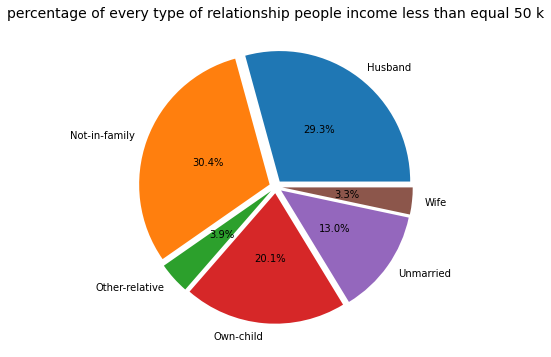

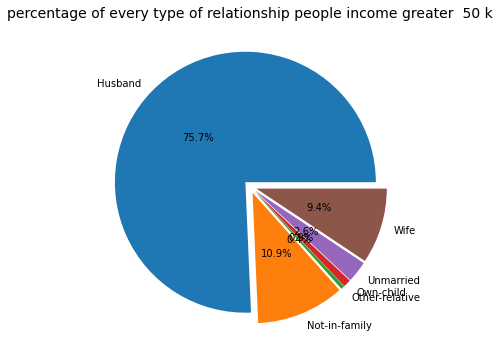

In [12]:
def create_pie_plot(data, title):
  pie, ax = plt.subplots(figsize=[10,6])
  labels = data.keys()
  plt.pie(x=data, autopct="%.1f%%", explode=[0.05]*len(data), labels=labels, pctdistance=0.5)
  plt.title(title, fontsize=14);
  plt.show()


# See how much percentage of every type of relationship people income less than equal 50 k
less_than_fity_data = raw_data[raw_data["income"] == "<=50K"]
less_than_fity_value = less_than_fity_data.groupby("relationship")["income"].count()
create_pie_plot(less_than_fity_value, "percentage of every type of relationship people income less than equal 50 k")


# See how much percentage of every type of relationship people income greater equal 50 k
greater_than_fity_data = raw_data[raw_data["income"] == ">50K"]
greater_than_fity_value = greater_than_fity_data.groupby("relationship")["income"].count()
create_pie_plot(greater_than_fity_value, "percentage of every type of relationship people income greater  50 k")




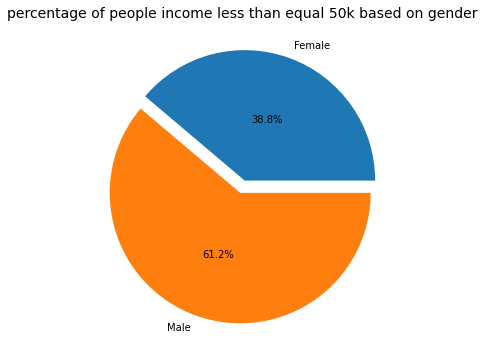

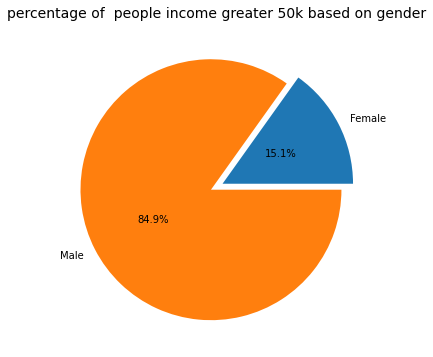

In [13]:
# See how much percentage of every type of relationship people income less than equal 50 k
less_than_fity_data = raw_data[raw_data["income"] == "<=50K"]
less_than_fity_value = less_than_fity_data.groupby("sex")["income"].count()
create_pie_plot(less_than_fity_value, "percentage of people income less than equal 50k based on gender")


# See how much percentage of every type of relationship people income greater equal 50 k
greater_than_fity_data = raw_data[raw_data["income"] == ">50K"]
greater_than_fity_value = greater_than_fity_data.groupby("sex")["income"].count()
create_pie_plot(greater_than_fity_value, "percentage of  people income greater 50k based on gender")



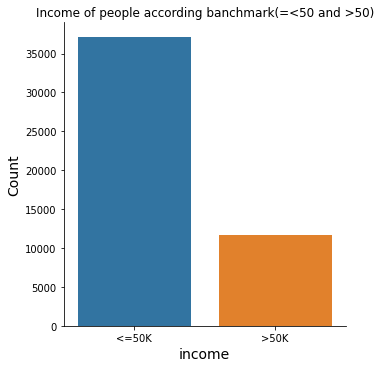

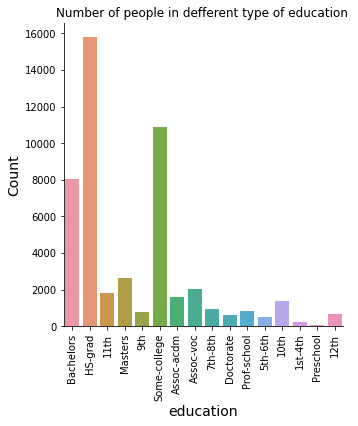

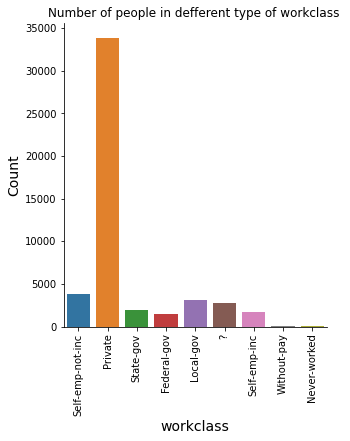

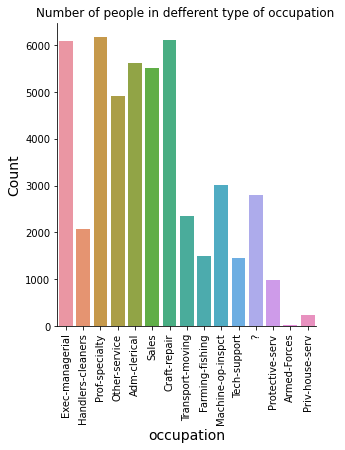

In [14]:
# create bar plot to exratct more visual discription of data


def create_bar_plot(data_frame_for_bar, column_name, title, rotate = None):

  data_frame = data_frame_for_bar[[column_name]]
  sn.catplot( x=column_name,
              kind="count", 
              data=data_frame,
              height=5)
  plt.xlabel(column_name, size=14)
  plt.ylabel("Count", size=14)
  plt.tight_layout()
  plt.title(title)
  if rotate:
    plt.xticks(rotation=rotate)

  plt.show()


bar_plot_with_income = create_bar_plot(raw_data, "income", "Income of people according banchmark(=<50 and >50)")
bar_plot_with_education = create_bar_plot(raw_data, "education", "Number of people in defferent type of education ",90)
bar_plot_with_workclass = create_bar_plot(raw_data, "workclass", "Number of people in defferent type of workclass ", 90)
bar_plot_with_occupation = create_bar_plot(raw_data, "occupation", "Number of people in defferent type of occupation ", 90)

In [15]:
# feature extract and preprocees feature
# raw_data.head()
level_data_frame.head()


age  workclass  finalnlweight  ...  hours-per-week  native-country  income
0   50          6          83311  ...              13              39       0
1   38          4         215646  ...              40              39       0
2   53          4         234721  ...              40              39       0
3   28          4         338409  ...              40               5       0
4   37          4         284582  ...              40              39       0

[5 rows x 15 columns]

In [16]:
def train_test_split(level_data_frame, train_size = 80):

  train_size = train_size /100
  msk = np.random.rand(len(level_data_frame)) <train_size

  test_data = level_data_frame[~msk]

  train_data = level_data_frame[msk]

  return train_data , test_data

train_data_extract, test_data_extract = train_test_split(level_data_frame, 75)

def extract_feature_target(data_for_extract_x_y, target_name):
  target_ = level_data_frame['income'].values
  feature_ = level_data_frame.drop(['income'], axis = 1).values

  return feature_, target_ 

train_feature , train_target = extract_feature_target(train_data_extract, "income")
test_feature , test_target = extract_feature_target(test_data_extract, "income")



In [17]:
# Train model and fit data  


def train_and_fit_model(data, train_feature, train_target):
  #kNeighborsClassifier
  kn_classifier_model = KNeighborsClassifier(n_neighbors = 7)
  kn_classifier_model.fit(train_feature, train_target)

  #LinearSVC classifier
  linear_svc_model = LinearSVC()
  linear_svc_model.fit(train_feature, train_target)

  # AdaBoost classifier 
  adaboost_classifier_model = AdaBoostClassifier(n_estimators=50,learning_rate=1)
  adaboost_classifier_model.fit(train_feature, train_target)


  return kn_classifier_model, linear_svc_model, adaboost_classifier_model

kn_classifier_model,linear_svc_model,adaboost_classifier_model=train_and_fit_model(level_data_frame,train_feature, train_target )

  

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



In [18]:
# load models and predict


def load_model_predict_and_accuracy(model, test_feature):
  target_predict_model = model.predict(test_feature)
  accuracy_model = round(accuracy_score(test_target,target_predict_model), 4)

  return accuracy_model, target_predict_model

knn_model_accuracy, knn_target_predict = load_model_predict_and_accuracy(kn_classifier_model, test_feature)
svc_model_accuracy, target_predict = load_model_predict_and_accuracy(linear_svc_model, test_feature)
adaboost_classifier_model_accuracy, adaboost_target_predict = load_model_predict_and_accuracy(adaboost_classifier_model, test_feature)




0.7949


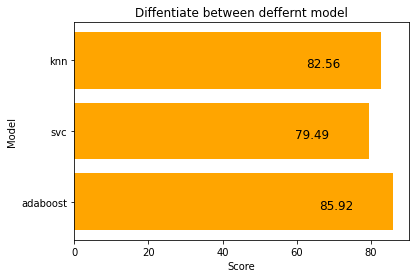

In [19]:
print(svc_model_accuracy)

# accuracy compare between deffernt model
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()

# Example data
model_name = ["knn", "svc", "adaboost"]
y_pos = np.arange(len(model_name))
accuracy_score = [knn_model_accuracy*100,round(svc_model_accuracy*100,2), adaboost_classifier_model_accuracy*100 ]
error = np.random.rand(len(model_name))

ax.barh(y_pos, accuracy_score, align='center', color = "Orange")
ax.set_yticks(y_pos)
ax.set_yticklabels(model_name)

ax.invert_yaxis() 
ax.set_xlabel('Score')
ax.set_ylabel('Model')
ax.set_title('Diffentiate between deffernt model')
# formatter = ticker.FormatStrFormatter('$%1.2f')
# ax.xaxis.set_major_formatter(formatter)

totals = []

for i in ax.patches:
    totals.append(i.get_width())
total = sum(totals)
for j, i  in enumerate(ax.patches):
  ax.text(i.get_width()-20, i.get_y()+.5, \
          str(accuracy_score[j]), fontsize=12, color='Black')


plt.show()

In [20]:
#Get the confusion matrix


def showConfusionMatrix(y,ypred):
    cf_matrix = confusion_matrix(y, ypred)
    sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

Confusion Metrix for Knn Algorithm


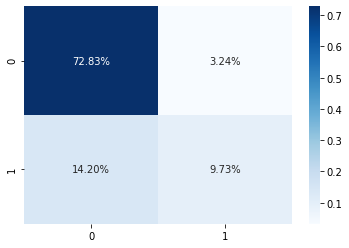

In [21]:

print("Confusion Metrix for Knn Algorithm")
showConfusionMatrix(test_target,knn_target_predict)

Confusion Metrix for SVC Algorithm


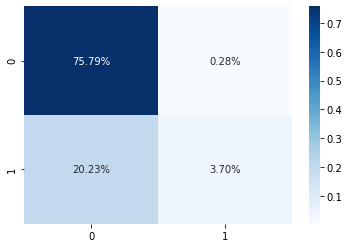

In [22]:
print("Confusion Metrix for SVC Algorithm")
showConfusionMatrix(test_target,target_predict)


Confusion Metrix for AdaBoost Algorithm


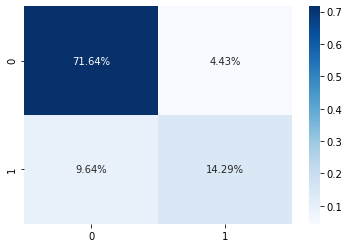

In [23]:

print("Confusion Metrix for AdaBoost Algorithm")
showConfusionMatrix(test_target,adaboost_target_predict)

In [24]:
print ('Classification Matrix for Knn:')
print (classification_report(test_target,knn_target_predict))

print ('Classification Matrix for SVc:')
print (classification_report(test_target,target_predict))

print ('Classification Matrix for adaboost_target_predict:')
print (classification_report(test_target,adaboost_target_predict))

Classification Matrix for Knn:
              precision    recall  f1-score   support

           0       0.84      0.96      0.89     37153
           1       0.75      0.41      0.53     11687

    accuracy                           0.83     48840
   macro avg       0.79      0.68      0.71     48840
weighted avg       0.82      0.83      0.81     48840

Classification Matrix for SVc:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88     37153
           1       0.93      0.15      0.26     11687

    accuracy                           0.79     48840
   macro avg       0.86      0.58      0.57     48840
weighted avg       0.82      0.79      0.73     48840

Classification Matrix for adaboost_target_predict:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     37153
           1       0.76      0.60      0.67     11687

    accuracy                           0.86     48840
   macro avg   

In [25]:
false_positive_rateKNN, true_positive_rateKNN, thresholdKNN = roc_curve(test_target, knn_target_predict)
false_positive_rateSVC, true_positive_rateSVC, thresholdSVC = roc_curve(test_target, target_predict)


false_positive_rateAda, true_positive_rate_ada, threshold_ada = roc_curve(test_target, adaboost_target_predict)

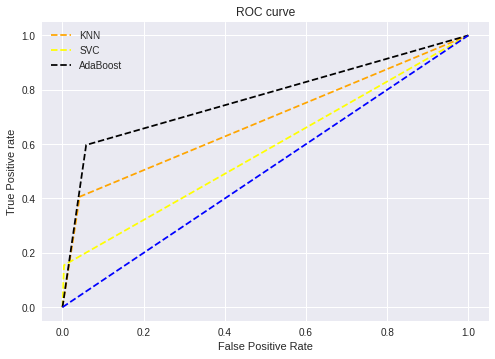

In [26]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(false_positive_rateKNN, true_positive_rateKNN, linestyle='--',color='orange', label='KNN')
plt.plot(false_positive_rateSVC, true_positive_rateSVC, linestyle='--',color='yellow', label='SVC')

plt.plot(false_positive_rateAda, true_positive_rate_ada, linestyle='--',color='black', label='AdaBoost')

#plt.plot(false_positive_rateEp, false_positive_rateEp, linestyle=':',color='aqua', label='Extra Tree')
plt.plot([0, 1], linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();